In [7]:
! pip install -q kaggle


In [8]:
from google.colab import files
files.upload()
     

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apollopubg","key":"3c6e2519fa3fc29b6143e88f14a90408"}'}

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:

! kaggle datasets download -d aftabhussaincui/refined-rnsa-ct-scans-12k-pngs
! unzip refined-rnsa-ct-scans-12k-pngs.zip

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout, SpatialDropout2D ,BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os, random, shutil
from random import uniform
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

# import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

In [12]:
dataset_path = 'RNSA_Subset_PNGs_12K'

In [13]:
! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'

In [13]:
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.84, 0.15, 0.01
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

In [ ]:
# folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# obj = {
#     "any":[],
#     ""
# }
# # Initialize empty lists to store the file paths for each set
# train_set, validation_set, test_set = [], [], []

# # Loop over each folder and split the PNG images into sets
# for folder in folders:
#     # Get the folder name (label)
#     folder_name = os.path.basename(folder)
#     # Get a list of all the PNG images in the folder
#     png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
#     random.shuffle(png_images)
#     # Define the percentage split for train, validation, and test sets
#     train_percent, validation_percent, test_percent = 0.84, 0.15, 0.01
#     # Split the PNG images into train, validation, and test sets
#     num_files = len(png_images)
#     train_end = int(num_files * train_percent)
#     validation_end = int(num_files * (train_percent + validation_percent))
#     train_set += png_images[:train_end]
#     validation_set += png_images[train_end:validation_end]
#     test_set += png_images[validation_end:]

In [15]:
for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in ['Normal', 'Epidural_Positive','Intraventricular_Positive', 'Subdural_Positive', 'Intraparenchymal_Positvie', 'Subarachnoid_Positive', 'Any_Positive']:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, folder_name), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, folder_name)
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 10080
Validation set size: 1800
Test set size: 120


In [2]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Train",
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical'
)

Found 6571 images belonging to 7 classes.


In [3]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_generator = test_datagen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Validation",
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical'
)

# test_generator = test_datagen.flow_from_directory(
#     os.path.join(
#         'dataset',
#         'test'
#     ),
#     target_size=(256, 256),
#     color_mode='rgb',
#     class_mode=None
# )

Found 1604 images belonging to 7 classes.


In [4]:
from tensorflow import keras
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [128,128,3], padding='same'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(7, activation ='softmax')])

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks = [early_stopping, reduce_lr]

In [ ]:
METRICS = [tf.keras.metrics.AUC(name='auc')]

    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS,)

model.summary()

In [8]:
history = model.fit(train_generator,   
                    validation_data=valid_generator,  
                     epochs=50) 

Epoch 1/50
206/206 [==============================] - 16s 76ms/step - loss: 1.1753 - auc: 0.8797 - val_loss: 1.2938 - val_auc: 0.8562
Epoch 2/50
206/206 [==============================] - 11s 52ms/step - loss: 1.1696 - auc: 0.8804 - val_loss: 1.4747 - val_auc: 0.8088
Epoch 3/50
206/206 [==============================] - 11s 54ms/step - loss: 1.1681 - auc: 0.8819 - val_loss: 1.3118 - val_auc: 0.8658
Epoch 4/50
206/206 [==============================] - 11s 54ms/step - loss: 1.1501 - auc: 0.8858 - val_loss: 1.2821 - val_auc: 0.8635
Epoch 5/50
206/206 [==============================] - 10s 51ms/step - loss: 1.1321 - auc: 0.8890 - val_loss: 1.4226 - val_auc: 0.8242
Epoch 6/50
206/206 [==============================] - 11s 52ms/step - loss: 1.1356 - auc: 0.8888 - val_loss: 1.3786 - val_auc: 0.8436
Epoch 7/50
206/206 [==============================] - 11s 54ms/step - loss: 1.1216 - auc: 0.8915 - val_loss: 1.3410 - val_auc: 0.8636
Epoch 8/50
206/206 [==============================] - 12s 58ms

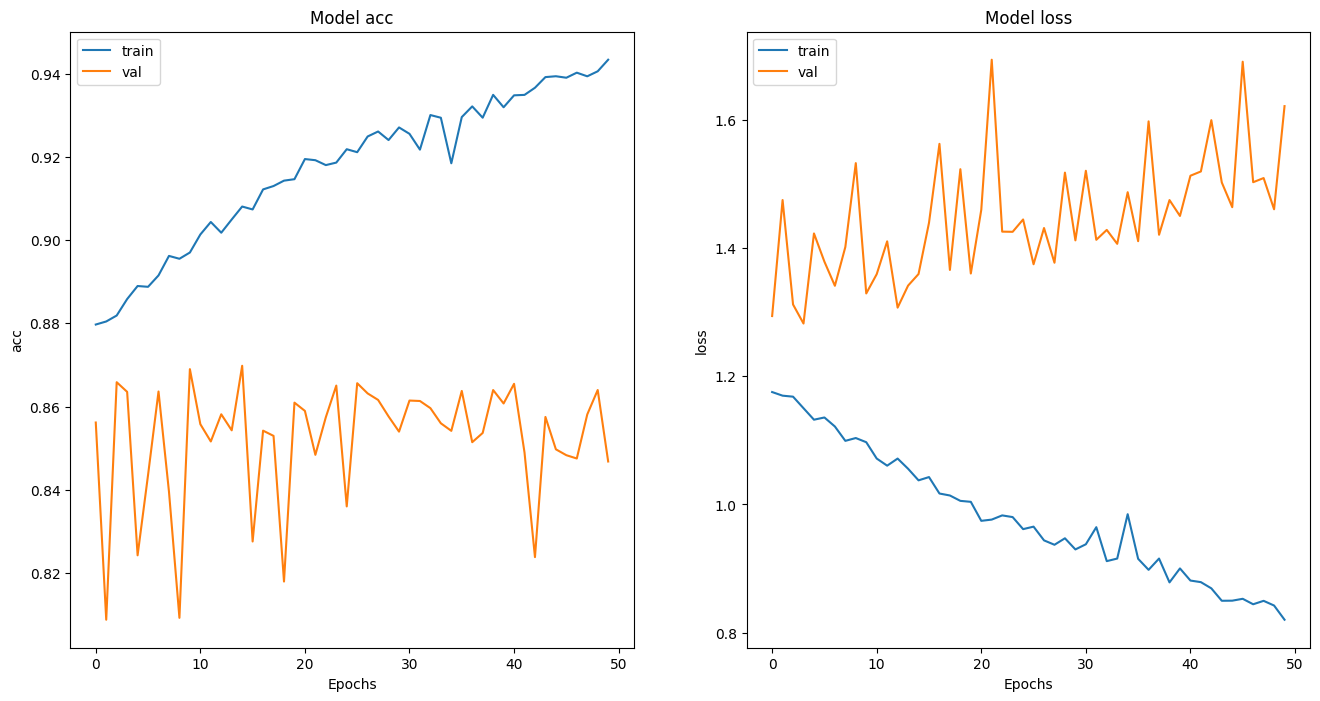

In [31]:

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax = ax.ravel()
metric_aa = ["acc", "loss"]
for i, metric in enumerate(["auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric_aa[i]))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric_aa[i])
    ax[i].legend(["train", "val"])

In [15]:

def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(128, 128))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])
    # Label array
    labels = {0: 'Any', 1: 'Epidural', 2: 'Intraparenchymal', 3: 'Intraventricular', 4: 'normal', 5: 'Subarachnoid',
              6: 'Subdural'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("pred:", predicted_class)
    print("correct :"+str(img_rel_path).split("/")[1], "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
     

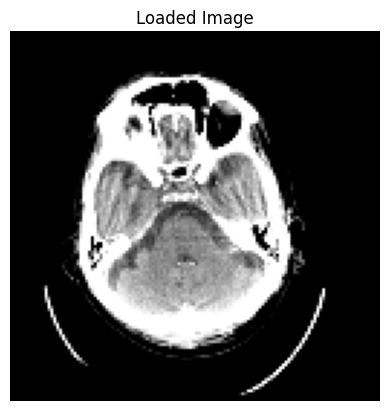

1/1 [==============================] - 0s 19ms/step


Maximum Probability:  0.58075374
pred: Any
correct :Any_Positive 



-------------------Individual Probability--------------------------------

ANY : 58.08 %
EPIDURAL : 0.12 %
INTRAPARENCHYMAL : 10.37 %
INTRAVENTRICULAR : 4.75 %
NORMAL : 11.24 %
SUBARACHNOID : 1.51 %
SUBDURAL : 13.92 %


In [24]:
predict(validation_set[583])

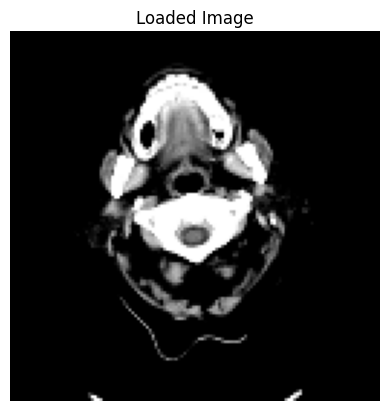

1/1 [==============================] - 0s 21ms/step


Maximum Probability:  0.99603003
pred: normal
correct :Subarachnoid_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.15 %
EPIDURAL : 0.08 %
INTRAPARENCHYMAL : 0.04 %
INTRAVENTRICULAR : 0.02 %
NORMAL : 99.6 %
SUBARACHNOID : 0.08 %
SUBDURAL : 0.03 %


In [32]:
predict(validation_set[183])

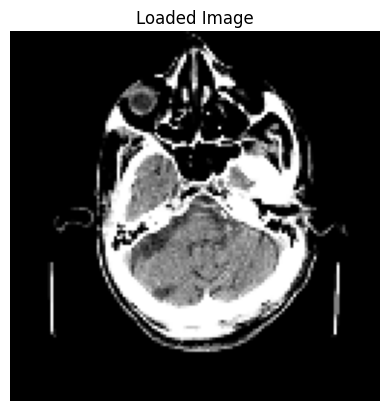

1/1 [==============================] - 0s 31ms/step


Maximum Probability:  0.9987368
pred: normal
correct :Subdural_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.08 %
EPIDURAL : 0.0 %
INTRAPARENCHYMAL : 0.01 %
INTRAVENTRICULAR : 0.0 %
NORMAL : 99.87 %
SUBARACHNOID : 0.03 %
SUBDURAL : 0.0 %


In [33]:
predict(validation_set[133])

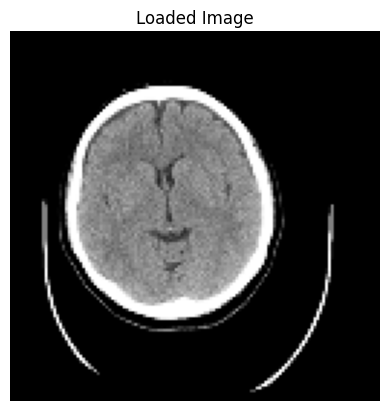

1/1 [==============================] - 0s 21ms/step


Maximum Probability:  0.5880843
pred: Subdural
correct :Subdural_Positive 



-------------------Individual Probability--------------------------------

ANY : 35.9 %
EPIDURAL : 0.09 %
INTRAPARENCHYMAL : 0.47 %
INTRAVENTRICULAR : 0.12 %
NORMAL : 3.9 %
SUBARACHNOID : 0.7 %
SUBDURAL : 58.81 %


In [36]:
predict(validation_set[983])

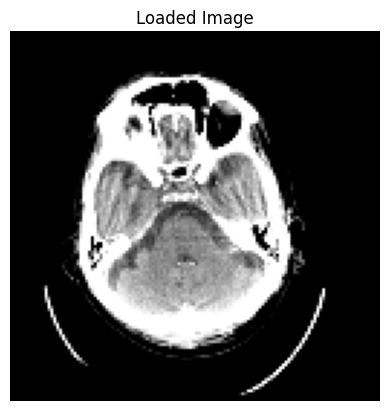

1/1 [==============================] - 0s 19ms/step


Maximum Probability:  0.58075374
pred: Any
correct :Any_Positive 



-------------------Individual Probability--------------------------------

ANY : 58.08 %
EPIDURAL : 0.12 %
INTRAPARENCHYMAL : 10.37 %
INTRAVENTRICULAR : 4.75 %
NORMAL : 11.24 %
SUBARACHNOID : 1.51 %
SUBDURAL : 13.92 %


In [37]:
predict(validation_set[583])

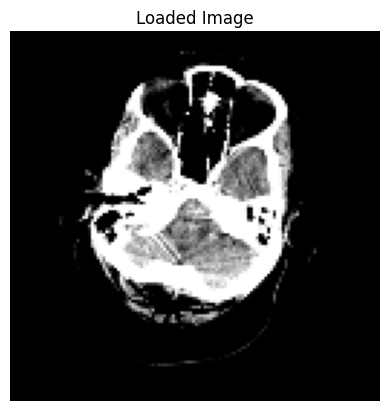

1/1 [==============================] - 0s 21ms/step


Maximum Probability:  0.9905218
pred: normal
correct :Any_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.65 %
EPIDURAL : 0.0 %
INTRAPARENCHYMAL : 0.01 %
INTRAVENTRICULAR : 0.01 %
NORMAL : 99.05 %
SUBARACHNOID : 0.09 %
SUBDURAL : 0.19 %


In [38]:
predict(validation_set[383])

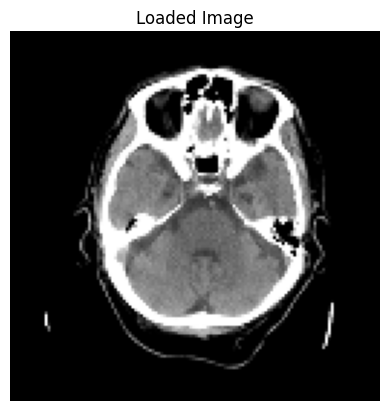

1/1 [==============================] - 0s 34ms/step


Maximum Probability:  0.72940373
pred: normal
correct :Epidural_Normal 



-------------------Individual Probability--------------------------------

ANY : 13.78 %
EPIDURAL : 0.0 %
INTRAPARENCHYMAL : 6.53 %
INTRAVENTRICULAR : 0.74 %
NORMAL : 72.94 %
SUBARACHNOID : 5.34 %
SUBDURAL : 0.67 %


In [39]:
predict(validation_set[683])